In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/realKnownCause/machine_temperature_system_failure.csv")
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["timestamp"])
df = df.set_index("timestamp")
df.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


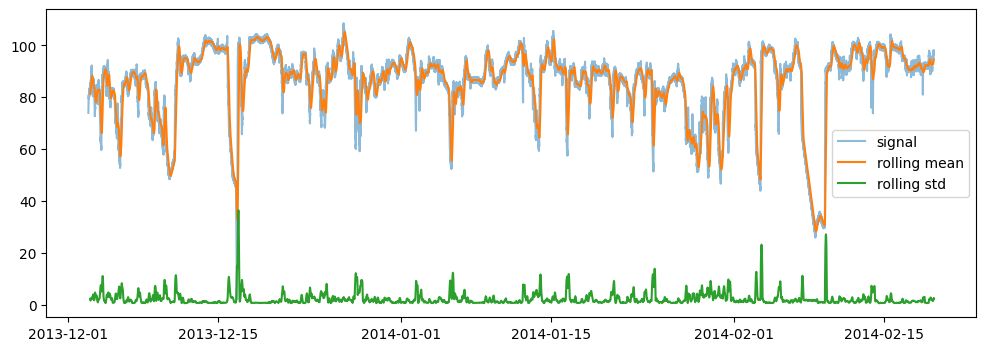

In [4]:
rolling_mean = df["value"].rolling(window=50).mean()
rolling_std = df["value"].rolling(window=50).std()
plt.figure(figsize=(12,4))
plt.plot(df["value"], alpha=0.5, label="signal")
plt.plot(rolling_mean, label="rolling mean")
plt.plot(rolling_std, label="rolling std")
plt.legend()
plt.show()

In [5]:
df["z_score"] = (df["value"] - rolling_mean) / rolling_std
df["anomaly"] = df["z_score"].abs() > 3
anomalies = df[df["anomaly"]]

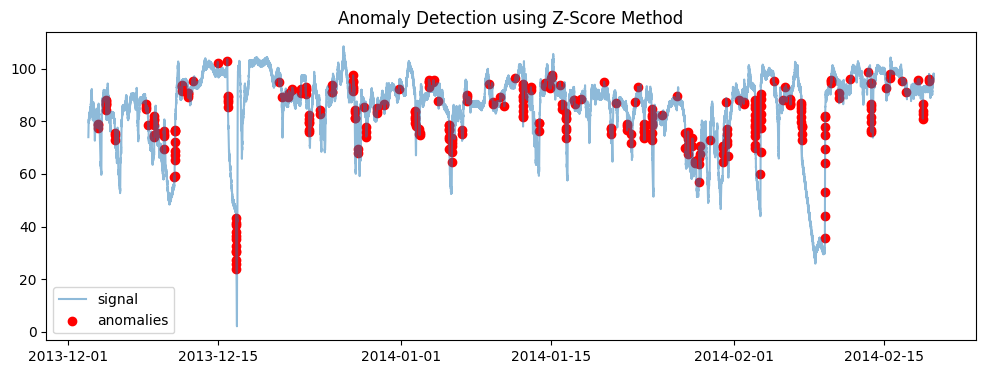

In [6]:
plt.figure(figsize=(12,4))
plt.plot(df["value"], alpha=0.5, label="signal")
plt.scatter(anomalies.index, anomalies["value"], color='red', label="anomalies")
plt.title("Anomaly Detection using Z-Score Method")
plt.legend()
plt.show()

In [7]:
from anomaly_detection.core.data_utils import load_timeseries
from anomaly_detection.core.models import IsoForestDetector, rolling_zscore

In [9]:
df = load_timeseries("../data/realKnownCause/machine_temperature_system_failure.csv")
series = df["value"]
iso = IsoForestDetector()
iso.fit(series)
iso_anomalies = iso.predict(series)

ValueError: Expected a 2-dimensional container but got <class 'pandas.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

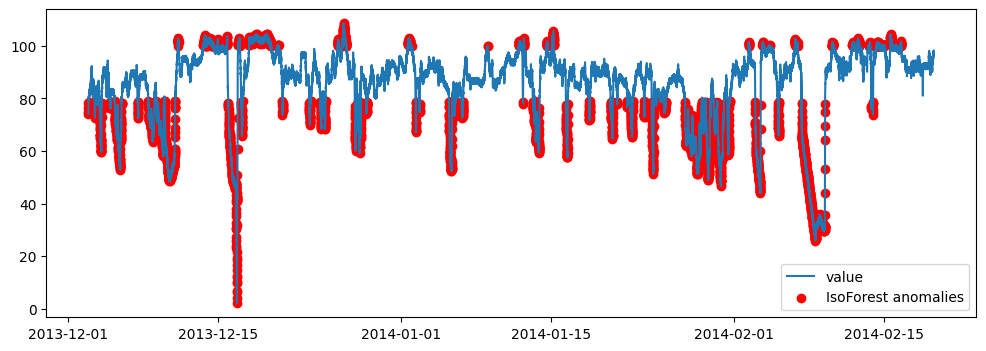

In [33]:
plt.figure(figsize=(12,4))
plt.plot(series.index, series.values, label="value")
plt.scatter(series.index[iso_anomalies], series.values[iso_anomalies], color='red', label="IsoForest anomalies")
plt.legend()
plt.show()

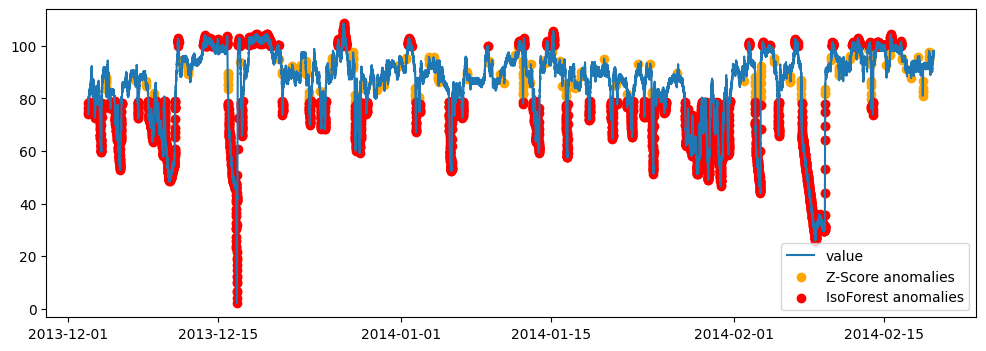

In [34]:
z, z_anoms = rolling_zscore(series)
plt.figure(figsize=(12,4))
plt.plot(series.index, series.values, label="value")
plt.scatter(series.index[z_anoms], series.values[z_anoms], color='orange', label="Z-Score anomalies")
plt.scatter(series.index[iso_anomalies], series.values[iso_anomalies], color='red', label="IsoForest anomalies")
plt.legend()
plt.show()

In [11]:
from anomaly_detection.core.features import build_features
feat_df = build_features(series)
feat_df.head()

,value,roll_mean,roll_std,roll_min,roll_max
timestamp,,,,,
2013-12-03 02:10:00,85.437842,81.903909,2.471006,73.967322,85.437842
2013-12-03 02:15:00,84.834840,82.085035,2.269469,74.935882,85.437842
2013-12-03 02:20:00,84.947158,82.251889,2.096364,76.124162,85.437842
2013-12-03 02:25:00,86.168619,82.419297,1.997456,78.140707,86.168619
2013-12-03 02:30:00,86.376219,82.556555,1.981356,78.710418,86.376219


In [12]:
len(series), len(feat_df)

(22695, 22636)

In [13]:
model = IsoForestDetector()
model.fit(feat_df)

In [14]:
anomaly_mask = model.detect_anomalies(feat_df)
anomaly_mask[:10]
len(anomaly_mask), len(feat_df)

(22636, 22636)

In [16]:
x_feat = feat_df.index
y_feat = series.loc[x_feat]
len(x_feat), len(y_feat), len(anomaly_mask)

x_anom = x_feat[anomaly_mask]
y_anom = y_feat.iloc[anomaly_mask]


IndexError: Boolean index has wrong length: 22636 instead of 22660

NameError: name 'y_anom' is not defined

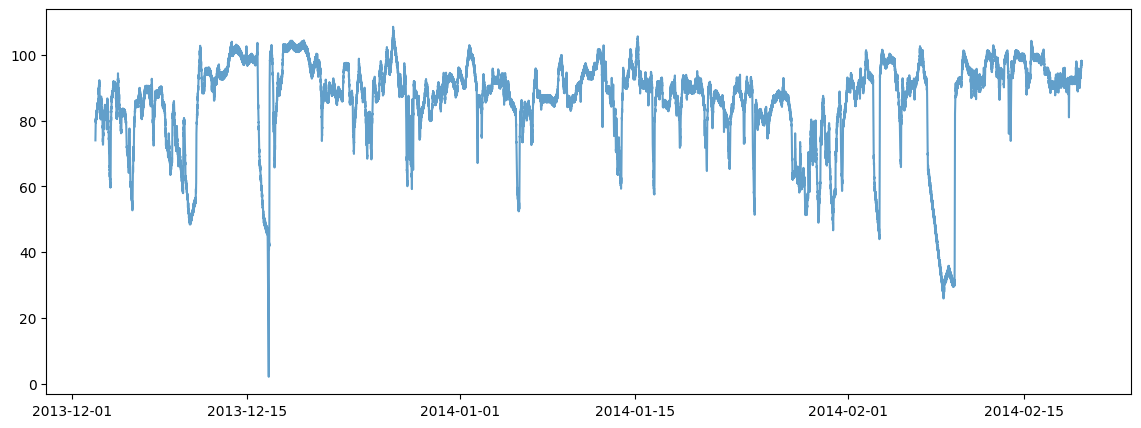

In [17]:
plt.figure(figsize=(14,5))

# plot full series
plt.plot(series.index, series.values, label="value", alpha=0.7)

# plot anomalies
plt.scatter(
    x_anom,
    y_anom,
    color="red",
    label="Isolation Forest anomalies"
)

plt.legend()
plt.title("Anomaly Detection Using Isolation Forest (Feature-Based)")
plt.show()
